Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from glob import glob

In [3]:
## If you are using the data by mounting the google drive, use the following : from google.colab import drive
from google.colab import drive
drive.mount('/content/gdrive')
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =  tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


80% of the images are using in the training set from the train folder

In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

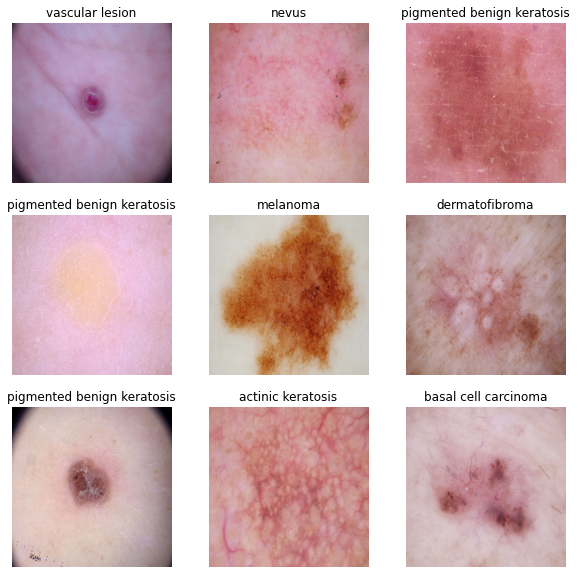

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for img,labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
  
])

we have rescaled the data before giving it as input to CNN

### Compile the model
Choose an appropirate optimiser and loss function for model training 

We are using Adam as Optimizer and SparseCategoricalCrossEntropy as loss function since it is a multi classification problem

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 24s 78ms/step - loss: 1.9484 - accuracy: 0.2924 - val_loss: 1.7485 - val_accuracy: 0.3691
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6054 - accuracy: 0.4297 - val_loss: 1.4119 - val_accuracy: 0.5369
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3796 - accuracy: 0.5212 - val_loss: 1.3938 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2977 - accuracy: 0.5346 - val_loss: 1.3998 - val_accuracy: 0.5526
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2210 - accuracy: 0.5670 - val_loss: 1.3389 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.0806 - accuracy: 0.6261 - val_loss: 1.3473 - val_accuracy: 0.5705
Epoch 7/20
56/56 [==============================] - 1s 23ms/step - loss: 1.0488 - accuracy: 0.6323 - val_loss: 1.4071 - val_accuracy: 0.5347
Epoch 8/20
5

### Visualizing training results

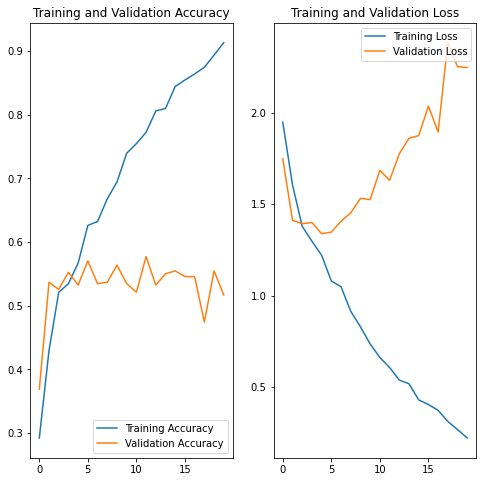

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Inferences:

  We can see the accuracy of training and validation are 0.9129(91.29%) and 0.5168(51.68%) which is very much overfitting.

  And also training loss is 0.2223 and validation loss is 2.2469.

In [17]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Applying following data augmentation strategy to reduce overfitting present in above model
## RandomFlip with horizontal_and_vertical mode
## RandomZoom with factor 0.2
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical', input_shape= (img_height, img_width, 3)),
     layers.experimental.preprocessing.RandomContrast([0.8, 1.0]),
     layers.experimental.preprocessing.RandomZoom(0.2),
     layers.experimental.preprocessing.RandomTranslation(height_factor=(0.2), width_factor=(0.2), fill_mode='reflect')                                 
])

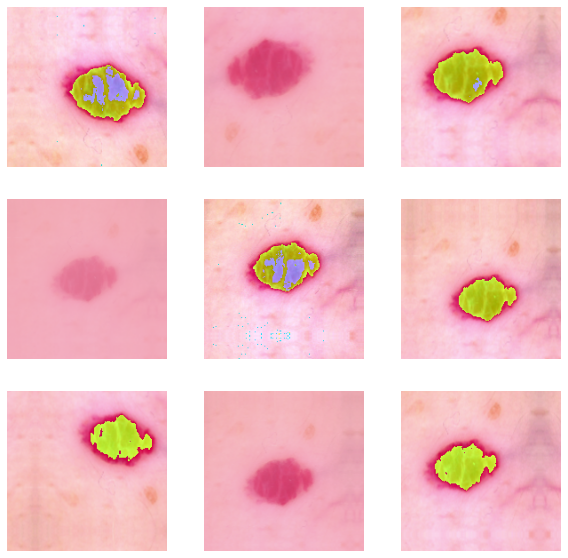

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## https://www.tensorflow.org/tutorials/images/data_augmentation
## https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 31ms/step - loss: 1.9803 - accuracy: 0.2723 - val_loss: 1.8635 - val_accuracy: 0.2998
Epoch 2/20
56/56 [==============================] - 2s 28ms/step - loss: 1.7377 - accuracy: 0.3661 - val_loss: 1.7058 - val_accuracy: 0.4161
Epoch 3/20
56/56 [==============================] - 2s 28ms/step - loss: 1.6127 - accuracy: 0.4353 - val_loss: 1.6249 - val_accuracy: 0.4295
Epoch 4/20
56/56 [==============================] - 2s 28ms/step - loss: 1.5647 - accuracy: 0.4286 - val_loss: 1.5721 - val_accuracy: 0.4385
Epoch 5/20
56/56 [==============================] - 2s 28ms/step - loss: 1.5449 - accuracy: 0.4425 - val_loss: 1.4932 - val_accuracy: 0.4631
Epoch 6/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4947 - accuracy: 0.4576 - val_loss: 1.5375 - val_accuracy: 0.4295
Epoch 7/20
56/56 [==============================] - 2s 27ms/step - loss: 1.5117 - accuracy: 0.4459 - val_loss: 1.4869 - val_accuracy: 0.4787
Epoch 8/20
56

### Visualizing the results

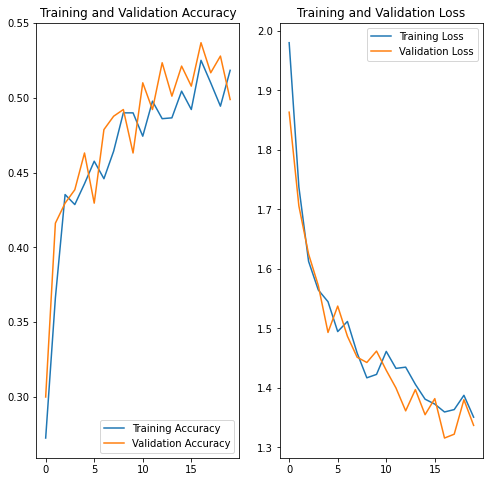

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Inferences:
We can see the trainig accuracy and validation accuracy as 0.5184(51.84%) and 0.4989(49.89%) respectively which implies the model is not overfitting.
But the model accuracy is low for both training and validation.
we can see the training loss: 1.3508 and  validation loss: 1.3370
is not reduced as well.



#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
from pathlib import Path


In [24]:
img_count = {}

for class_name in class_names:
    
    # Creating directory path concatenating train folder path and class names
    path = os.path.join(data_dir_train, class_name)
    
    # Creating path object with the class folder paths
    train_dir = pathlib.Path(path)
    
    # Storing class name and image count in each class in the dict variable
    img_count[class_name] = len(list(train_dir.glob('*.jpg')))
    
    # Calculating %Percentage imbalance
    dist_percent = round((img_count[class_name]/image_count_train)*100,3)
    
    # Printing the Results
    print("")
    print("Class Name: {0},  Image Count: {1} ({2}%)".format(class_name,img_count[class_name],dist_percent))
    
     
print("___________________________________________________________________")
print("")
print("")


Class Name: actinic keratosis,  Image Count: 114 (5.092%)

Class Name: basal cell carcinoma,  Image Count: 376 (16.793%)

Class Name: dermatofibroma,  Image Count: 95 (4.243%)

Class Name: melanoma,  Image Count: 438 (19.562%)

Class Name: nevus,  Image Count: 357 (15.945%)

Class Name: pigmented benign keratosis,  Image Count: 462 (20.634%)

Class Name: seborrheic keratosis,  Image Count: 77 (3.439%)

Class Name: squamous cell carcinoma,  Image Count: 181 (8.084%)

Class Name: vascular lesion,  Image Count: 139 (6.208%)
___________________________________________________________________




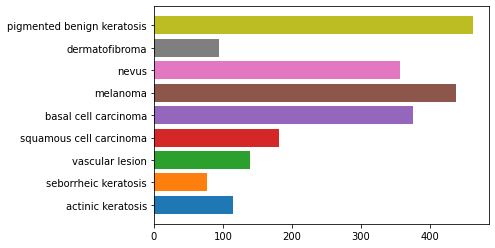

In [25]:
import os
path = '/content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train'
mn = 0
folders = ([name for name in os.listdir(path)
            if os.path.isdir(os.path.join(path, name))]) # get all directories 
for folder in folders:
    contents = os.listdir(os.path.join(path,folder)) # get list of contents
    if len(contents) >= mn: # if greater than the limit, print folder and number of contents
        plt.barh(folder,len(contents))

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
Seborrheic Keratosis has the least number of sample Image Count : 77 (3.439%).
#### - Which classes dominate the data in terms proportionate number of samples?
Pigmented Benign Keratosis dominate the data in terms proportionate number of samples with Image Count : 462 (20.634%)


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F75961AE7D0>: 100%|██████████| 500/500 [00:21<00:00, 23.64 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7626DCFC50>: 100%|██████████| 500/500 [00:21<00:00, 23.12 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F759618BE50>: 100%|██████████| 500/500 [00:21<00:00, 22.94 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F7626D49C50>: 100%|██████████| 500/500 [01:29<00:00,  5.58 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F7626D32D90>: 100%|██████████| 500/500 [01:29<00:00,  5.58 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7596189ED0>: 100%|██████████| 500/500 [00:21<00:00, 22.94 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7626D35FD0>: 100%|██████████| 500/500 [00:44<00:00, 11.32 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7596171950>: 100%|██████████| 500/500 [00:18<00:00, 27.12 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F75AA04E550>: 100%|██████████| 500/500 [00:18<00:00, 26.43 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
import glob


In [30]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033705.jpg_ca43a4d6-4211-4642-820c-6b789fffdc54.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_1d415598-7d52-4150-91eb-1f74dee962ea.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030826.jpg_c0345872-f677-46d5-85e9-0e72d52721c2.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_74c8d18d-ff66-4fbd-99ff-6a10e62792ee.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027950.jpg_528b8671-64fa-486a-af2a-166958e71bf6.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/MelanomaDetection/Train/actinic keratosis/output/actinic keratosis_o

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesson_list = [os.path.basename(os.path.dirname(y)) for y in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
dataframe_dict = dict(zip(path_list, lesson_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [34]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [36]:
data_dir_train= os.path.join(data_dir_train)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size = (img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

 Use Sequential from tensorflow.models library to build CNN model layer by layer
#### Below model used following layers:
1. First layer is used to rescalling the input of nural network from range [0, 255] to [0, 1]
2.  One convolution layers with filter size (1,1) and number of filters used 16 and padding as "same" (i.e. after convolution the output layer size will be same as input layer)
3. Five convolution layers with filter size (2,2) and number of filters used 16, 32 & 64 and padding as "same" (i.e. after convolution the output layer size will be same as input layer)
4. Three max pooling layer with filter size (2,2)
5.  One Flatten layer
6. One fully connected layer with 512 number of filters
7.  Output softmax layer
8.  Convolution and Fully connected layers used activation function 'relu'
9.  Used Dropout(0.29) after each convotution layer and Dropout(0.27) in FC layer
10. Used BatchNormalization in each convolution layer

In [38]:
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale = (1.0 / 255), input_shape=(img_height, img_width,3)))
model.add(layers.Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(16, kernel_size = (2,2), activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Dropout(0.29))

model.add(layers.Conv2D(32, kernel_size = (2,2), padding = 'same', activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, kernel_size = (2,2), activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Dropout(0.29))

model.add(layers.Conv2D(64, kernel_size = (2,2), padding = 'same', activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, kernel_size = (2,2), activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size = (2,2)))
model.add(layers.Dropout(0.29))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.27))
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      64        
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_7 (Conv2D)           (None, 179, 179, 16)      1040      
                                                                 
 batch_normalization_1 (Batc  (None, 179, 179, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 16)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
## your code goes here
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [40]:
epochs = 30
## Your code goes here, use 50 epochs.
history  = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 50s 280ms/step - loss: 4.8999 - accuracy: 0.3190 - val_loss: 34.4623 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 32s 183ms/step - loss: 1.5166 - accuracy: 0.4310 - val_loss: 29.0133 - val_accuracy: 0.1225
Epoch 3/30
169/169 [==============================] - 34s 191ms/step - loss: 1.3395 - accuracy: 0.4904 - val_loss: 7.3233 - val_accuracy: 0.3088
Epoch 4/30
169/169 [==============================] - 31s 179ms/step - loss: 1.2216 - accuracy: 0.5425 - val_loss: 4.4407 - val_accuracy: 0.4588
Epoch 5/30
169/169 [==============================] - 31s 179ms/step - loss: 1.1547 - accuracy: 0.5647 - val_loss: 5.4994 - val_accuracy: 0.4633
Epoch 6/30
169/169 [==============================] - 31s 180ms/step - loss: 1.0698 - accuracy: 0.5976 - val_loss: 1.8550 - val_accuracy: 0.5991
Epoch 7/30
169/169 [==============================] - 31s 181ms/step - loss: 0.9421 - accuracy: 0.6385 - val_loss: 1.6858 - val_accuracy: 0

#### **Todo:**  Visualize the model results

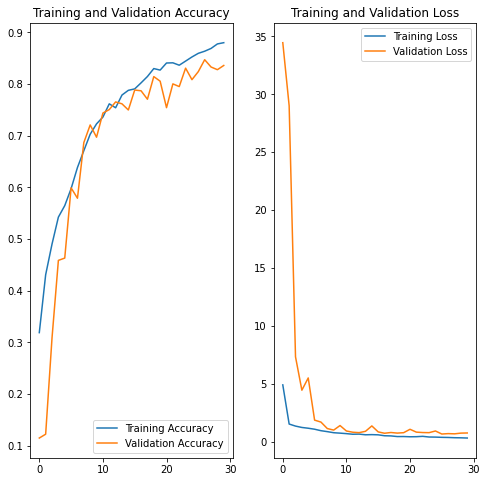

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



#### Inference:

1.   We can see from the aobve graphs , that the model is not at all Overfitted ,with the train accuracy of 0.8800 (88.00%) and validation accuracy of 0.8359(83.59%) which is an increase in accuracy of the model.
2.   We can see the train loss of 0.3079 and validation loss of 0.7449. which we can see that, Overall Loss is reduced.

3. After rectifying class imbalance by increasing the sample size in each class , we have seen significant improve in model accuracy and get rid of model Overfitment.

